Loading Data, Imports

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [2]:
# Get experiments data
!wget 'https://www.dropbox.com/s/65m633trsrk7qiz/mlflow.db?dl=0' -O 'mlflow.db'
!wget 'https://www.dropbox.com/s/hmajx2pzzfo9whi/mlruns.zip?dl=0' -O 'mlruns.zip' 
!unzip mlruns.zip -d /

--2023-06-05 19:39:51--  https://www.dropbox.com/s/65m633trsrk7qiz/mlflow.db?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/65m633trsrk7qiz/mlflow.db [following]
--2023-06-05 19:39:51--  https://www.dropbox.com/s/raw/65m633trsrk7qiz/mlflow.db
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0c9c5d9310aa2afb4e1d3c9a2b.dl.dropboxusercontent.com/cd/0/inline/B9aturRnz6aPRZxuQdBt-WV7OMiA_OTDVK3FUitGs4wbqaDOpkVdXZlVV1EZU01MrRyfFU0KzXM5DI7XUa6LFsfqZGaaPJ34m4R0CHY39aKSD6VGybVuDovUwOtnCDX40xaQ8o5V3MhkPo8iCZkDrfjrCRtQW3OSrbBfSkHhPjAuvw/file# [following]
--2023-06-05 19:39:52--  https://uc0c9c5d9310aa2afb4e1d3c9a2b.dl.dropboxusercontent.com/cd/0/inline/B9aturRnz6aPRZxuQdBt-WV7OMiA_OTDVK3FUitGs4wbqaDOpkVdXZlVV1EZU01MrRyfFU0KzXM5DI7XU

In [3]:
%%capture
%%bash
wget "https://www.dropbox.com/s/ormp9hgdyt6kefr/journey-springfield.zip?dl=0" -O journey-springfield.zip 
mkdir data

unzip journey-springfield.zip -d ./data 

mv ./data/testset ./data/test
mv ./data/train/simpsons_dataset ./data/
rmdir ./data/train
mv ./data/simpsons_dataset ./data/train

In [4]:
# Check if data exists
![ -d "./data/train" ] && echo "Directory ./data/train exists."
![ -d "./data/test" ] && echo "Directory ./data/testset exists."

Directory ./data/train exists.
Directory ./data/testset exists.


In [5]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt

import mlflow

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import torchmetrics
import time
import os
import copy
import pickle

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
# Choose processor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
# Define simple transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = './data/'

In [9]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
                  for x in ['train', 'test']}

In [10]:
# Split train data to train and val subsets
train_fraction = 0.8

train_size = round(train_fraction * len(image_datasets['train']))
val_size = len(image_datasets['train']) - train_size

print(f'Train subset size: {train_size}\nValid subset size: {val_size}\n')
train_set, val_set = torch.utils.data.random_split(image_datasets['train'], [train_size, val_size])

dsets = {'train': train_set, 'val': val_set}

dataset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

Train subset size: 16746
Valid subset size: 4187



In [11]:
# Create loaders
BATCH_SIZE = 32
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

test_loader = DataLoader(image_datasets['test'], batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2)

class_names = image_datasets['train'].classes

In [12]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

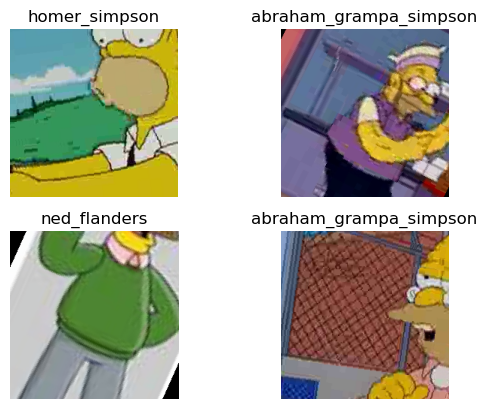

In [13]:
# Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
imshow(images[0], ax=ax0, normalize=True, title=image_datasets['train'].classes[labels[0]])
imshow(images[1], ax=ax1, normalize=True, title=image_datasets['train'].classes[labels[1]])
imshow(images[2], ax=ax2, normalize=True, title=image_datasets['train'].classes[labels[2]])
imshow(images[3], ax=ax3, normalize=True, title=image_datasets['train'].classes[labels[3]]);

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    param_model_name = str(model_ft.__class__).replace('.', '-')[8:-2]
    with mlflow.start_run(run_name=param_model_name):
        mlflow.log_param('optimizer', param_optimizer)
        mlflow.log_param('lr', param_lr)
        mlflow.log_param('batch_size', param_bs)
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                mlflow.log_metric(f'{phase}_epoch_loss', epoch_loss)
                mlflow.log_metric(f'{phase}_epoch_accuracy', epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    mlflow.pytorch.log_model(model_ft, artifact_path='models')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        mlflow.log_metric('best_accuracy', best_acc)
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
    
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], ax=ax, title=class_names[preds[j]])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
LR = 0.001

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 266MB/s]


In [17]:
# Hyperparameters to log
param_optimizer = str(optimizer_ft.__class__)[8:-2]
param_lr = optimizer_ft.state_dict()['param_groups'][0]['initial_lr']
param_bs = BATCH_SIZE

In [18]:
def run_mlflow():
    # run tracking UI in the background
    get_ipython().system_raw("mlflow ui --port 5000 --backend-store-uri sqlite:///mlflow.db &") # run tracking UI in the background

    ### run here

    # create remote tunnel using ngrok.com to allow local port access
    # borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

    from pyngrok import ngrok
    # Terminate open tunnels if exist
    ngrok.kill()

    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    NGROK_AUTH_TOKEN = "2QbvkNkFfJgD1wDiD1gASh53VKq_7PNxKw7RQtSf44Sk6pGUX"
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [19]:
# run_mlflow()
# mlflow.set_tracking_uri('sqlite:///mlflow.db')
# mlflow.set_experiment('resnet-baseline')

In [20]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                           num_epochs=20)

In [21]:
def compute_f1(model, loader):
    was_training = model.training
    model.eval()
    f1_hist = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            f1 = torchmetrics.functional.f1_score(preds, labels, task="multiclass", num_classes=len(class_names))
            f1_hist.append(f1.cpu())
    model.train(mode=was_training)
    return np.mean(f1_hist)

In [22]:
# Use trained model to make predictions and compute f1 score
model_path = '/kaggle/working/mlruns/1/785c5af13dc348139a04578b8a48b62c/artifacts/models/data/model.pth'
model_trained_resnet = torch.load(model_path)
avg_f1_resnet = compute_f1(model_trained_resnet, dataloaders['train'])
print('Train f1:', avg_f1_resnet)
avg_f1_resnet = compute_f1(model_trained_resnet, dataloaders['val'])
print('Validation f1:', avg_f1_resnet)

Train f1: 0.9886689
Validation f1: 0.98974234


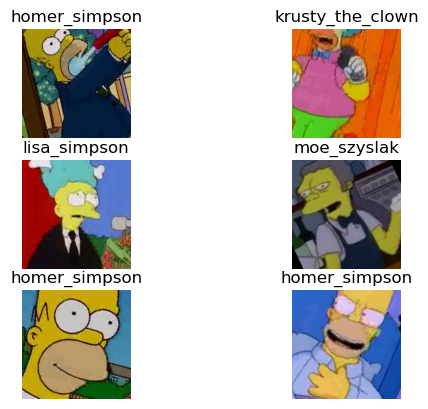

In [23]:
visualize_model(model_trained_resnet, num_images=6)

In [24]:
# Predict classes on test data

def predict(model):
    was_training = model.training
    model.eval()
    predictions = np.empty((0, 1))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_array = preds.cpu().unsqueeze(1)
            predictions = np.vstack((predictions, preds_array))
    
    model.train(mode=was_training)
    return predictions
predictions = pd.Series(predict(model_trained_resnet).squeeze(), name='Expected').apply(lambda x: class_names[int(x)])
predictions.shape

(991,)

In [25]:
filenames = pd.Series([item[0].replace('./data/test/testset/', '') for item in image_datasets['test'].samples], name='Id')

submission_df = pd.concat((filenames, predictions), axis=1).set_index('Id')
submission_df

,Expected
Id,
img0.jpg,nelson_muntz
img1.jpg,ned_flanders
img10.jpg,ned_flanders
img100.jpg,chief_wiggum
img101.jpg,apu_nahasapeemapetilon
...,...
img987.jpg,nelson_muntz
img988.jpg,charles_montgomery_burns
img989.jpg,charles_montgomery_burns


In [26]:
submission_df.to_csv('submission_01.csv')

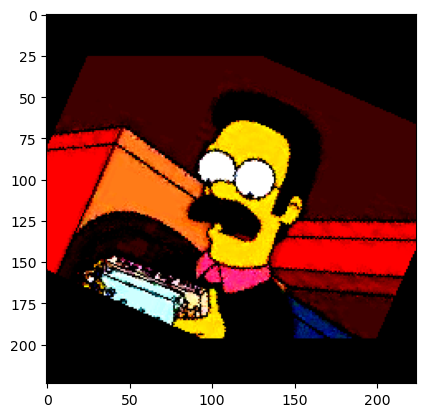

In [27]:
img, label = image_datasets['test'][85]
img_np = img.numpy().transpose((1, 2, 0))  # convert to numpy and transpose dimensions

plt.imshow(img_np)
plt.show()

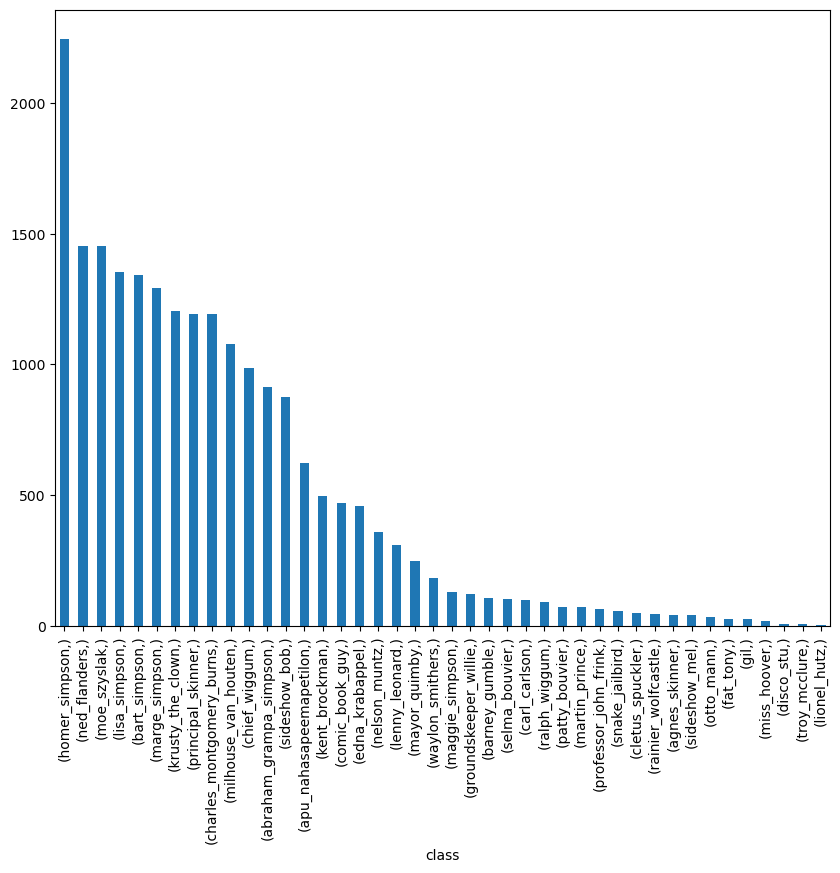

In [28]:
classes = pd.DataFrame(image_datasets['train'].targets, columns=['class']).applymap(lambda x: class_names[x])
plt.figure(figsize=(10,8))
classes.value_counts().plot(kind='bar')

plt.show()

In [29]:
# Backup mlruns
# !zip -r mlruns.zip /kaggle/working/mlruns